In [1]:
import sys
sys.path.append('../..')

import eeg_decoder
import numpy as np
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sista
%load_ext autoreload
%autoreload 2

In [2]:
experiment_name = 'C01'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1000])
print(exp.nsub)

23


In [3]:
from pathlib import Path

k_files = sorted(list(Path(data_dir).glob('*k.csv')))
subix = [str(x.name)[4:6] for x in exp.xdata_files] 
subix_k = [str(k.name)[4:6] for k in k_files]
subMatch=[subix.index(str(sub)) for sub in subix_k]

exp.xdata_files = [exp.xdata_files[i] for i in subMatch]
exp.ydata_files = [exp.ydata_files[i] for i in subMatch]
exp.info_files =  [exp.info_files[i] for i in subMatch]
exp.nsub = len(exp.xdata_files)
print(exp.nsub)

19


In [4]:
# function to calculate k

def get_sub_k(filename):
    beh=pd.read_csv(filename).to_dict('list')
    resp=np.array(beh["key_press"])[pd.notna(beh["key_press"])]
    chg=np.array(beh["change"])[pd.notna(beh["change"])]
    hit=np.logical_and(resp=='n',chg==1)
    fa=np.logical_and(resp=='n',chg==0)

    k = 6 * (sum(hit)/sum(chg) - sum(fa)/sum(chg==0))
    return k

In [5]:
time_window = 50
time_step = 50
trial_bin_size = 20
n_splits = 3
group_dict = OrderedDict([('1',[11]),('1 (hashtag)',[12]),('1 (letter)',[13]),('Set size 2',[20])])
train_labels = ['1','Set size 2']
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict,train_labels=train_labels)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)

In [6]:
for isub in range(exp.nsub):

    print(isub)
    xdata,ydata = exp.load_eeg(isub)
    xdata,ydata = wrangl.group_labels(xdata,ydata)

    for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata):

        X_train_all, y_train = wrangl.select_training_data(X_train_all, y_train) 
        X_train_all, y_train = wrangl.balance_labels(X_train_all, y_train)
        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):

            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)
        wrangl.ifold+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [7]:
interp = eeg_decoder.Interpreter(clfr)
# interp.save_results()

In [8]:
k = []
for s in k_files:
    k.append(get_sub_k(s))

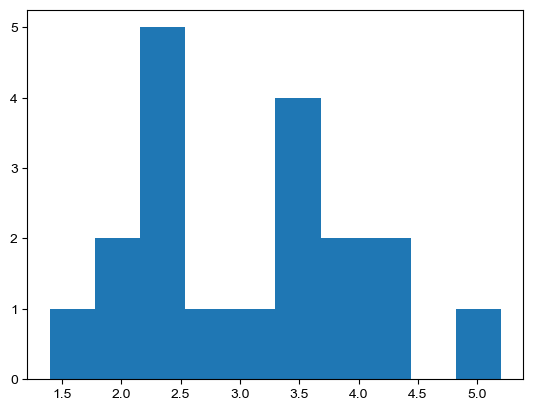

In [9]:
plt.hist(k)
plt.show()

In [10]:
conf_scores = np.mean(np.mean(interp.confidence_scores[:,interp.t>0],2),1)

In [11]:
df = pd.DataFrame(conf_scores,columns=wrangl.labels)
df

,1,1 (hashtag),1 (letter),Set size 2
0,-0.439676,0.753438,-0.592368,0.162559
1,-0.950621,-0.790233,-0.102462,1.024012
2,-2.067201,0.003089,0.798658,1.248231
3,-3.467175,-1.026953,-0.568747,1.786954
4,-1.657741,0.834629,-0.451065,1.848781
5,-0.726153,0.568279,0.463001,0.879027
6,-1.290203,-1.204584,0.432005,0.348188
7,-0.809738,0.345180,1.464626,1.450234
8,-1.003916,0.145192,0.464482,0.278368
9,-0.802965,1.296063,0.635526,-0.156919


In [12]:
diff1 = df['1'] - df['1 (hashtag)']
diff2 = df['1'] - df['1 (letter)']
diff3 = diff1 - diff2 

In [13]:
def regression_line(slope: float, intercept: float):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--',color='k',zorder=-1)

def plot_corr(x: list, y: list, plot_title = None, x_variable_name = 'X Variable', y_variable_name = 'Y Variable', stats_text = True, stat_xy=(0,0)):
    """Plot correlation between two variables of equal length"""

    # Use scipy.stats.linregress to calc correlation
    slope, intercept, r_value, p_value, std_err = sista.linregress(x, y)
    stats = {'slope':slope, 'intercept':intercept, 'r_value':r_value, 'p_value':p_value, 'std_err':std_err}
    
    # Plotting variables
    ax = plt.subplot(111)
    ax.scatter(x,y,edgecolor='k',color='dodgerblue')

    # Plotting regression line
    regression_line(slope,intercept)

    # Plot labelling
    r_value_round = round(r_value**2,2)
    p_value_round = round(p_value,4)
    if stats_text:
        stats_string = f'$r^2$ = {r_value_round}\np = {p_value_round}'
        plt.text(stat_xy[0],stat_xy[1],stats_string,fontsize=12,bbox=dict(facecolor='none', edgecolor='lightgrey', boxstyle='round'))

    if plot_title:
        full_title = (plot_title)
        plt.title(full_title,fontsize=18)
    
    plt.xlabel(x_variable_name, fontsize=14)
    plt.ylabel(y_variable_name, fontsize=14)

    # Various plot beautification
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)

    
    return stats

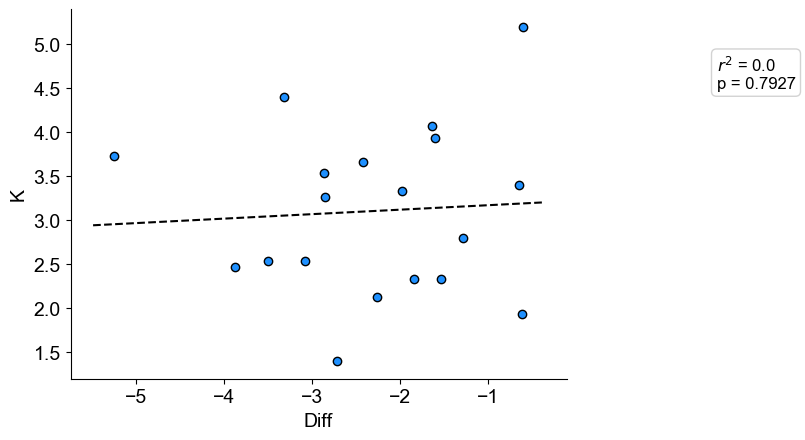

In [20]:
import scipy.stats as sista
diff12 = df['1'] - df['Set size 2']
plot_corr(diff12,k,stat_xy=(1.6,4.5),x_variable_name='Diff',y_variable_name='K')
plt.show()

In [15]:
mean_acc = np.mean(np.mean(interp.acc[:,interp.t>0],2),1)

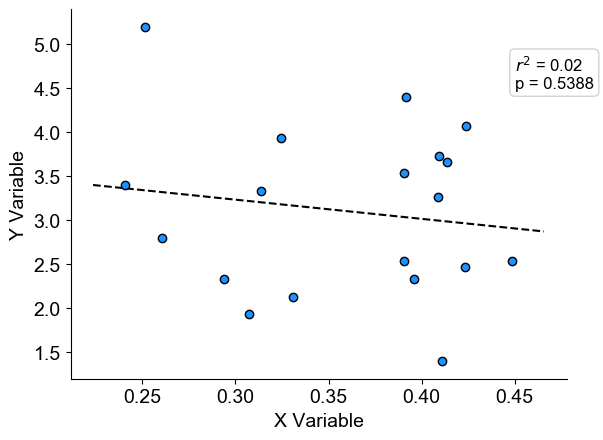

In [16]:
plot_corr(mean_acc,k,stat_xy=(.45,4.5),)
plt.show()

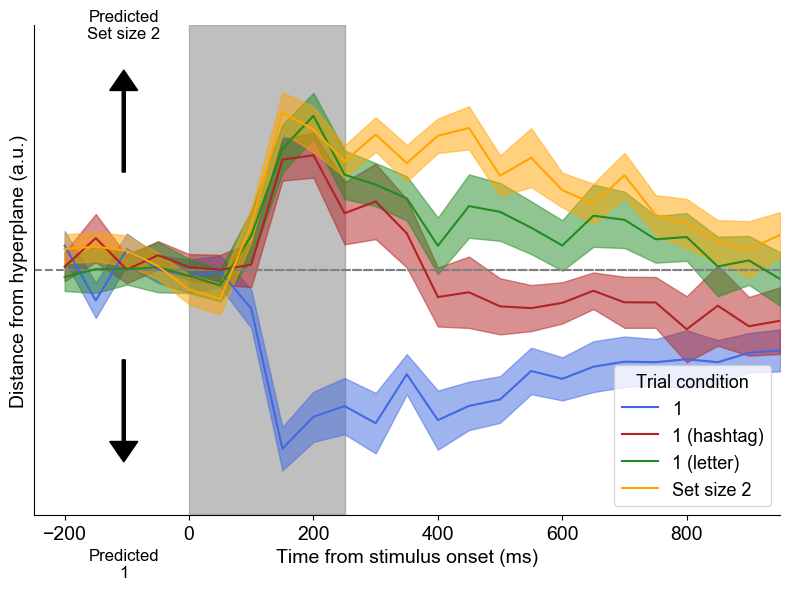

In [17]:
plt.subplots(figsize=(8,6))
interp.plot_hyperplane(ylim=[-3,3],stim_label_xy=[130,3.1])

No handles with labels found to put in legend.


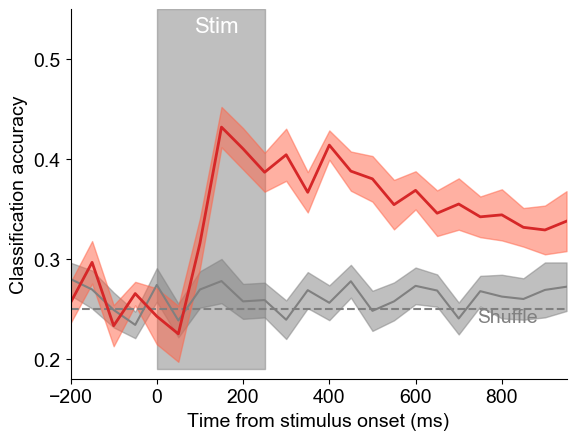

Mean delay accuracy: 0.36145174444046624
Mean delay S.D.: 0.025681581468865566


In [18]:
interp.plot_acc()